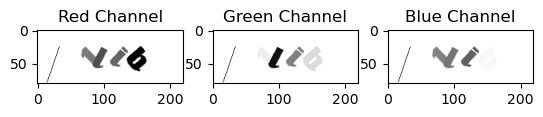

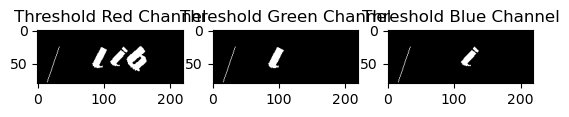

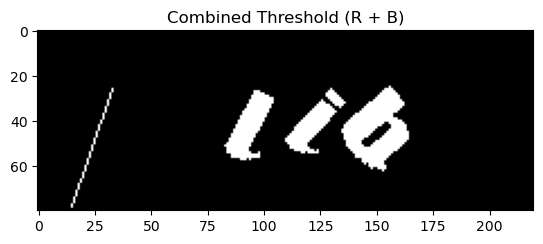

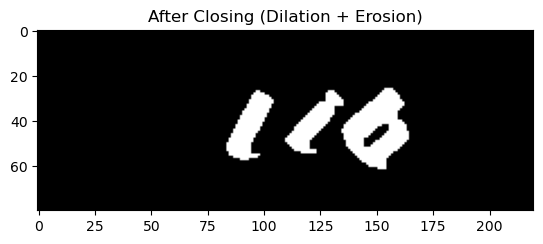

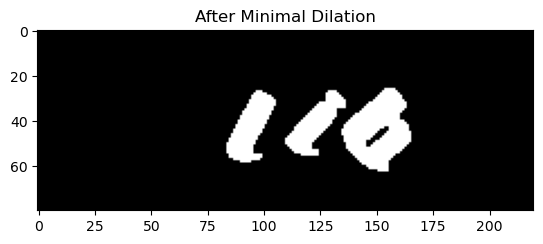

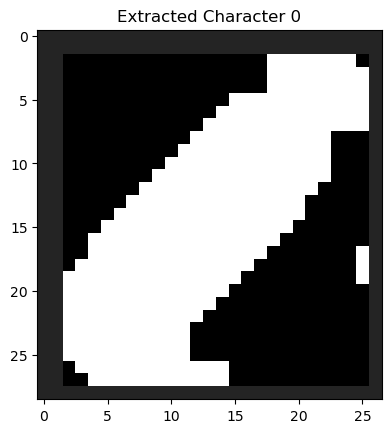

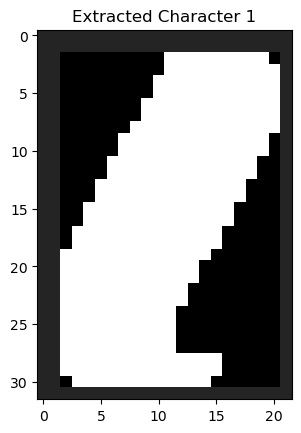

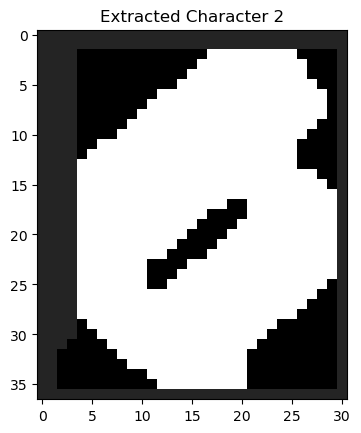

Segmentation completed!


In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Create output folder for segmented characters
output_folder = "extracted_letter_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the CAPTCHA image (colored image)
image_path = "train/1lib-0.png"
# image_path = "train/0axhfa-0.png"
image = cv2.imread(image_path)

# Split the image into its Red, Green, and Blue channels
(B, G, R) = cv2.split(image)

# Display each channel to inspect differences
plt.subplot(131)
plt.imshow(R, cmap='gray')
plt.title('Red Channel')
plt.subplot(132)
plt.imshow(G, cmap='gray')
plt.title('Green Channel')
plt.subplot(133)
plt.imshow(B, cmap='gray')
plt.title('Blue Channel')
plt.show()

# Threshold each channel separately
_, thresh_R = cv2.threshold(R, 100, 255, cv2.THRESH_BINARY_INV)
_, thresh_G = cv2.threshold(G, 100, 255, cv2.THRESH_BINARY_INV)
_, thresh_B = cv2.threshold(B, 100, 255, cv2.THRESH_BINARY_INV)

# Display the thresholded results for each channel
plt.subplot(131)
plt.imshow(thresh_R, cmap='gray')
plt.title('Threshold Red Channel')
plt.subplot(132)
plt.imshow(thresh_G, cmap='gray')
plt.title('Threshold Green Channel')
plt.subplot(133)
plt.imshow(thresh_B, cmap='gray')
plt.title('Threshold Blue Channel')
plt.show()

# Combine the channels if needed (depending on character separation)
combined_thresh = cv2.bitwise_or(thresh_R, thresh_B)  # Example: Combining Red and Blue

# Display the combined threshold
plt.imshow(combined_thresh, cmap='gray')
plt.title('Combined Threshold (R + B)')
plt.show()

# Now you can apply morphological operations and contour detection as before
# Apply median blur to reduce noise
combined_thresh = cv2.medianBlur(combined_thresh, 3)

# Apply Closing (Dilation followed by Erosion) to fill gaps
kernel = np.ones((3, 3), np.uint8)
img_closing = cv2.morphologyEx(combined_thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(img_closing, cmap='gray')
plt.title('After Closing (Dilation + Erosion)')
plt.show()

# Apply minimal Dilation (smaller kernel, fewer iterations)
dilation_kernel = np.ones((2, 2), np.uint8)
dilated = cv2.dilate(img_closing, dilation_kernel, iterations=1)
plt.imshow(dilated, cmap='gray')
plt.title('After Minimal Dilation')
plt.show()

# Find contours after thresholding and dilation
cnts = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

min_area = 50  # Adjusted min area for smaller characters
image_number = 0

for c in cnts:
    area = cv2.contourArea(c)
    if area > min_area:
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = float(w) / h
        if 0.2 < aspect_ratio < 1.0 and w > 5 and h > 15:
            # Draw a rectangle around each detected character
            cv2.rectangle(dilated, (x, y), (x + w, y + h), (36, 255, 12), 2)
            # Extract each character as a Region of Interest (ROI)
            ROI = dilated[y:y+h, x:x+w]
            plt.imshow(ROI, cmap='gray')
            plt.title(f'Extracted Character {image_number}')
            plt.show()
            # Save the character as an individual image
            cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
            image_number += 1

print("Segmentation completed!")